# Feature Engineering
## Import Libraries

In [121]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import mutual_info_score

## Import Train and Test Datasets

In [6]:
y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
X_train = pd.read_csv('Data/X_train_undersampled_data.csv')
y_test = pd.read_csv('Data/y_test.csv')
X_test = pd.read_csv('Data/X_test.csv')

In [7]:
X_train.columns

Index(['type_of_meal_plan_meal plan 1', 'type_of_meal_plan_meal plan 2',
       'type_of_meal_plan_meal plan 3', 'type_of_meal_plan_not selected',
       'room_type_reserved_room_type 1', 'room_type_reserved_room_type 2',
       'room_type_reserved_room_type 3', 'room_type_reserved_room_type 4',
       'room_type_reserved_room_type 5', 'room_type_reserved_room_type 6',
       'room_type_reserved_room_type 7', 'market_segment_type_aviation',
       'market_segment_type_complementary', 'market_segment_type_corporate',
       'market_segment_type_offline', 'market_segment_type_online',
       'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'required_car_parking_space', 'repeated_guest', 'no_of_adults_scaled',
       'no_of_children_scaled', 'no_of_weekend_nights_scaled',
       'no

## Define Helper Functions for Visualization

In [56]:
def custom_KDE(x_column_name):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot the kernel density estimate (KDE) for each group
    sns.kdeplot(data=pd.concat([X_train, y_train], axis=1), x=x_column_name, hue='booking_status', ax=ax, fill=True)

    # Set the title
    ax.set_title(f'Relationship between {x_column_name} and Booking Status')

    # Show the plot
    plt.show()
    
def custom_heatmap(x_column_name):
    crosstab = pd.crosstab(pd.concat([X_train, y_train], axis=1)['booking_status'], pd.concat([X_train, y_train], axis=1)[x_column_name])

    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt='g')

    # Set the title
    plt.title(f'Relationship between Booking Status and {x_column_name}')

    # Show the plot
    plt.show()

def custom_displot(x_column_name):
    # Plot the distribution for each group
    sns.displot(data=pd.concat([X_train, y_train], axis=1), x=x_column_name, hue='booking_status', discrete=True, height=4, aspect=1.5)

    # Set the title
    plt.title(f'Relationship between {x_column_name} and Booking Status')

    # Show the plot
    plt.show()

## Feature Engineering on Number of Customers

There are several ways to capture the relationship between no_of_adults and no_of_children:
1. sum of the 2 variables to represent the total number of customers
2. whether the customer is a solo traveller (only one adult or one child)
3. customer type with the following categories (adults only, children only and mix of adults and children)
4. percentage of adults (number of adults/total number of customers)

We will create features with all the possible methods and visualize the resulted variables.

In [10]:
# this function will be used to create customers number related features
def process_customer_number(df):
    df["no_of_customers"] = df['no_of_adults'] + df['no_of_children']
    df["solo_traveller"] = ((df["no_of_adults"]==1) & (df["no_of_children"]==0)) | ((df["no_of_adults"]==0) & (df["no_of_children"]==1))
    df['perc_adults'] = df['no_of_adults']/df["no_of_customers"]
    
    def get_traveller_type(x):
        if (x["no_of_adults"]>0) & (x["no_of_children"]==0):
            return 'adults_only'
        elif (x["no_of_adults"]==0) & (x["no_of_children"]>0):
            return 'children_only'
        else:
            return 'mixed'
    df["traveller_type"] = df.apply(get_traveller_type, axis=1)

In [11]:
process_customer_number(X_train)
process_customer_number(X_test)

In [19]:
customer_number_cols = ["no_of_customers", "perc_adults", "solo_traveller", "traveller_type"]

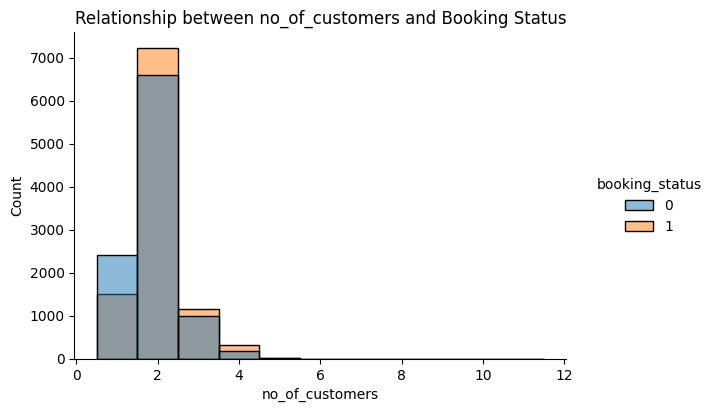

In [57]:
custom_displot(customer_number_cols[0])

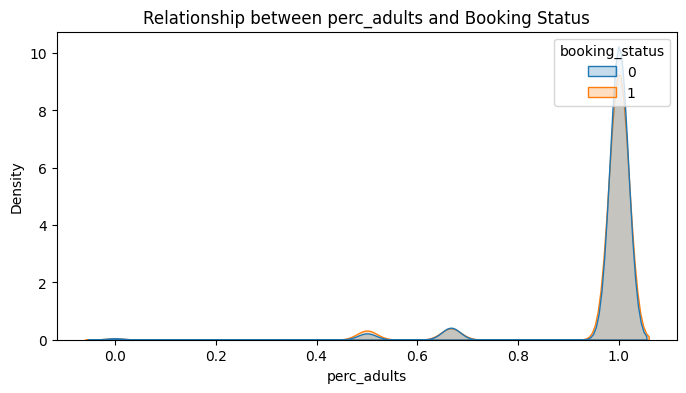

In [32]:
custom_KDE(customer_number_cols[1])

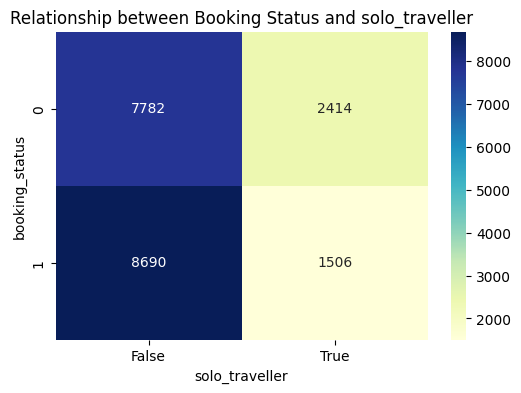

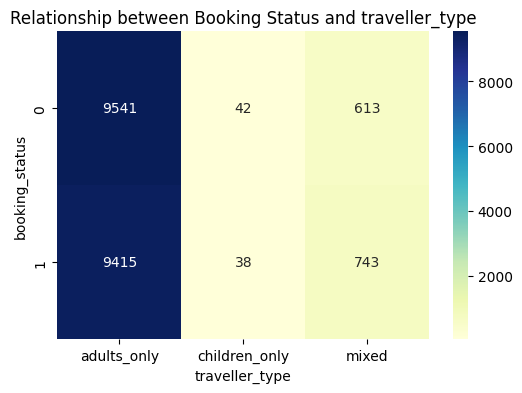

In [21]:
for col in customer_number_cols[2:]:
    custom_heatmap(col)

From the graphs, some patterns can be visualized:
1. solo traveller has a lower cancellation rate, which is likely to be because they have more control over their schedule and are less likely to have schedule conflict
2. most of the traveller groups consist of only adults, and they tend to have a lower cancellation rate compared to when mixing with children

## Feature Engineering on Number of Nights

There are several ways to capture the relationship between no_of_weekend_nights and no_of_week_nights:
1. sum of the 2 variables to represent the total number of nights stayed
2. customer type with the following categories (hour room, weekend only, weekday only and mix of both)
3. percentage of weekday nights (number of weekday nights/total number of nights)
4. difference between weekday nights and weekend nights, and regularized by the total number of nights

We will create features with all the possible methods and visualize the resulted variables.

In [173]:
# this function will be used to create nights number related features
def process_nights_number(df):
    df["no_of_nights"] = df['no_of_weekend_nights'] + df['no_of_week_nights']
    df["perc_weekday_nights"] = df['no_of_weekend_nights']/df["no_of_nights"]
    df["diff_nights"] = (df['no_of_week_nights']-df['no_of_weekend_nights'])/df["no_of_nights"]
    
    def get_stay_type(x):
        if (x["no_of_weekend_nights"]==0) & (x["no_of_week_nights"]==0):
            return 'hour_room'
        elif (x["no_of_weekend_nights"]>0) & (x["no_of_week_nights"]==0):
            return 'weekend_only'
        elif (x["no_of_weekend_nights"]==0) & (x["no_of_week_nights"]>0):
            return 'weekday_only'
        else:
            return 'mixed'
    df["stay_type"] = df.apply(get_stay_type, axis=1)

    # replace nan with 0
    df["perc_weekday_nights"] = df["perc_weekday_nights"].apply(lambda x: 0 if math.isnan(x) else x)
    df["diff_nights"] = df["diff_nights"].apply(lambda x: 0 if math.isnan(x) else x)

In [174]:
process_nights_number(X_train)
process_nights_number(X_test)

In [62]:
nights_number_cols = ["no_of_nights", "perc_weekday_nights", "diff_nights", "stay_type"]

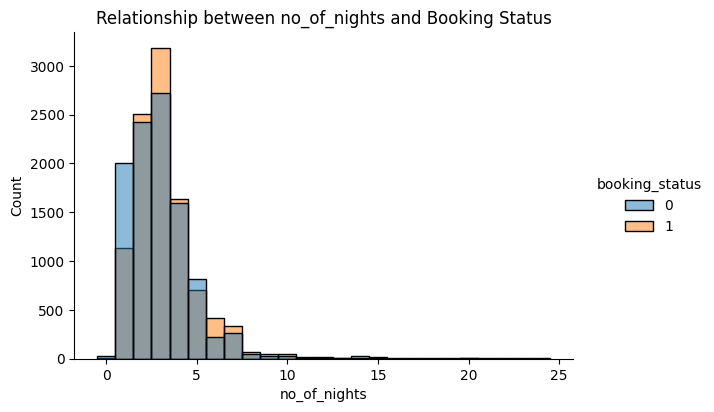

In [58]:
custom_displot(nights_number_cols[0])

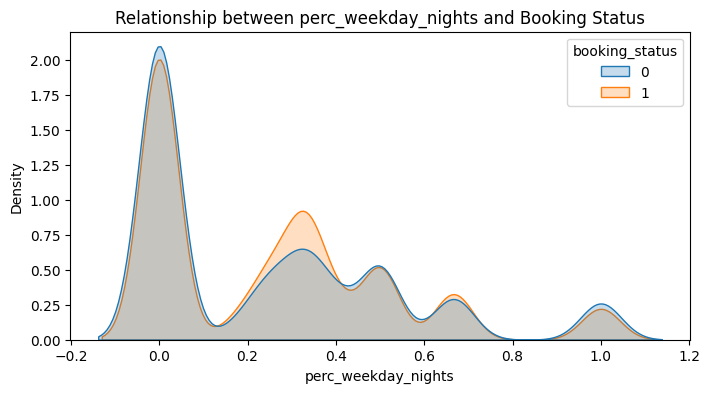

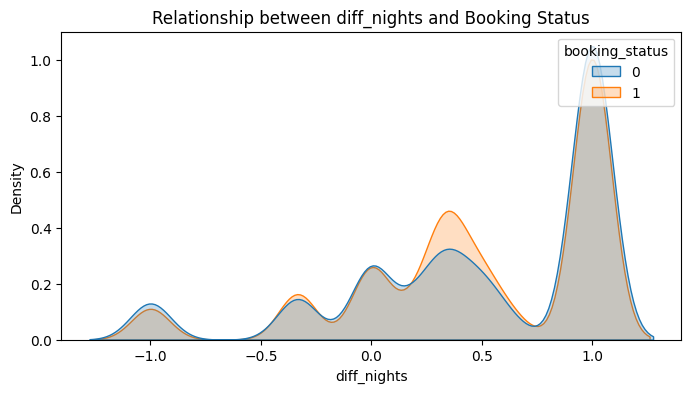

In [65]:
for col in nights_number_cols[1:3]:
    custom_KDE(col)

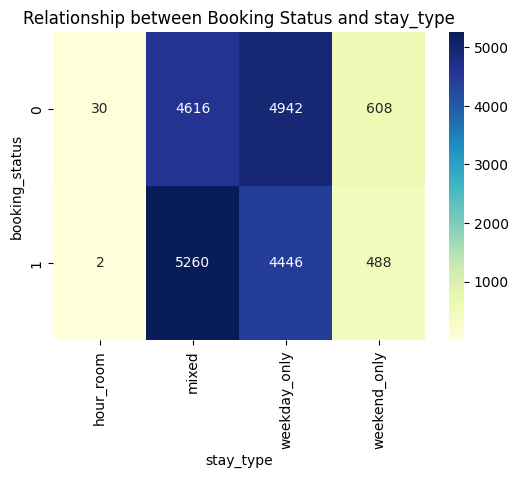

In [60]:
custom_heatmap(nights_number_cols[2])

From the graphs, some patterns can be visualized:
1. the cancellation rates seem to grow as the total number of nights stayed increases, especially when it is greater than 5 nights
2. weekday only stay type has a relatively low cancellation rate, which is likely to be because for this kind of trip, customers are likely to prepare ahead, such as applying for leave, and refrain from changing
3. when the percentage of weekday nights is between 0.2 and 0.4, there is a notably higher cancellation rate, similar trend can be found when the difference in weekday and weekend nights is around 0.4

## Feature Engineering on Previous Bookings

There are several ways to capture the relationship between no_of_previous_cancellations and no_of_previous_bookings_not_canceled:
1. sum of the 2 variables to represent the total number of previous bookings
2. cancellation rate based on previous bookings (number of cancelled/number of previous bookings)
3. cancellation type with the following categories (no previous booking, never cancelled before, all previous bookings are cancelled, mix of cancelled and successful stay)

We will create features with all the possible methods and visualize the resulted variables.

In [70]:
# this function will be used to create previous bookings related features
def process_previous_booking(df):
    df["no_of_previous_bookings"] = df['no_of_previous_cancellations'] + df['no_of_previous_bookings_not_canceled']
    df["previous_cancellation_rate"] = df.apply(lambda x: 0 if x["no_of_previous_bookings"]==0 else x['no_of_previous_cancellations']/x["no_of_previous_bookings"], axis=1)
    
    def get_cancellation_type(x):
        if (x["no_of_previous_cancellations"]==0) & (x["no_of_previous_bookings_not_canceled"]==0):
            return 'no_booking'
        elif (x["no_of_previous_cancellations"]>0) & (x["no_of_previous_bookings_not_canceled"]==0):
            return 'all_cancelled'
        elif (x["no_of_previous_cancellations"]==0) & (x["no_of_previous_bookings_not_canceled"]>0):
            return 'all_successful'
        else:
            return 'mixed'
    df["cancellation_type"] = df.apply(get_cancellation_type, axis=1)

In [71]:
process_previous_booking(X_train)
process_previous_booking(X_test)

In [72]:
previous_booking_cols = ["no_of_previous_bookings", "previous_cancellation_rate", "cancellation_type"]

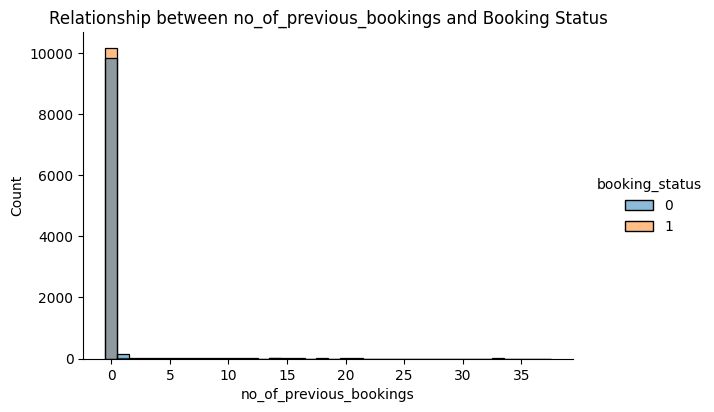

In [73]:
custom_displot(previous_booking_cols[0])

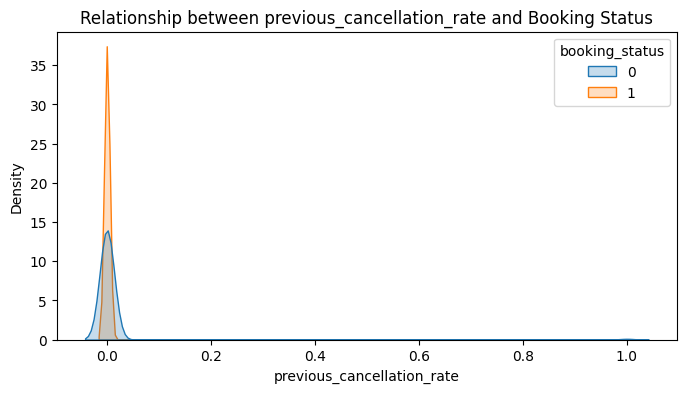

In [74]:
custom_KDE(previous_booking_cols[1])

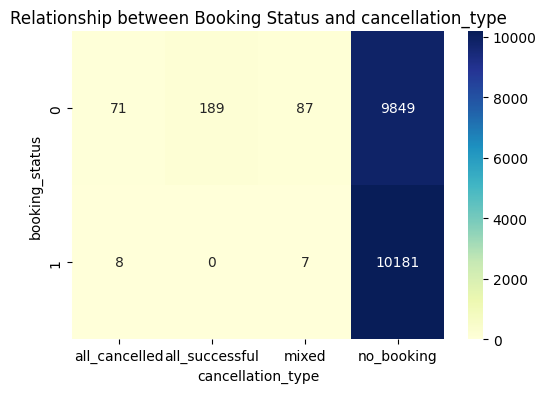

In [75]:
custom_heatmap(previous_booking_cols[2])

From the graphs, some patterns can be visualized:
1. when customers have previous bookings with the hotel, no matter cancelled or not, the customers are likely to have a lower cancellation rate, however, most customers do not have bookings before, which can be verified by the repeated_guest column

## Feature Engineering on Continuous Variables

lead_time and avg_price_per_room are 2 numerical variables with substantial number of unique values, we could categorize them by binning, which may be able to represent additional information.

In [82]:
# this function will be used to bin numerical features
def process_numerical(df):
    def binning(x):
        if x<=50:
            return '0 to 50'
        elif x<=100:
            return '50 to 100'
        elif x<=150:
            return '100 to 150'
        elif x<=200:
            return '150 to 200'
        elif x<=300:
            return '200 to 300'
        else:
            return 'greater than 300'
    # lead_time
    df['lead_time_cat'] = df['lead_time'].apply(binning)

    # avg_price_per_room
    df['avg_price_per_room_cat'] = df['avg_price_per_room'].apply(binning)

In [83]:
process_numerical(X_train)
process_numerical(X_test)

In [78]:
binned_numerical_cols = ["lead_time_cat", "avg_price_per_room_cat"]

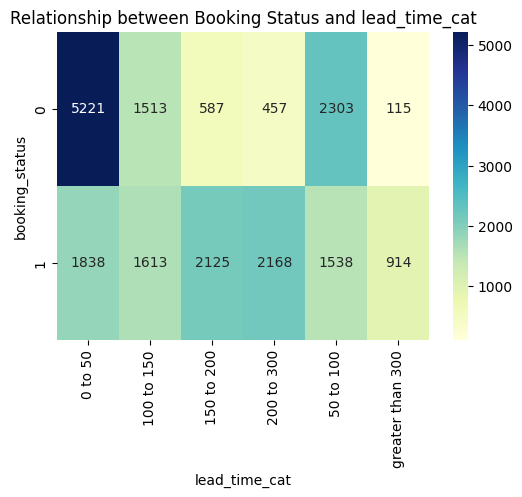

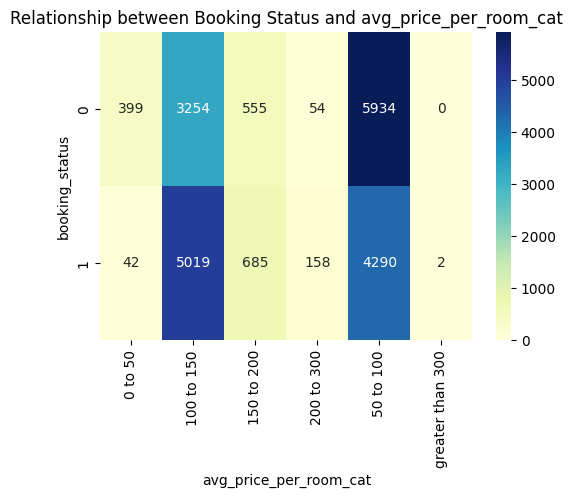

In [84]:
for col in binned_numerical_cols:
    custom_heatmap(col)

Some groups show clear difference in their cancellation behaviour, for example, when the lead_time is between 0 and 50, there are not many cancellations, while when the lead_time is between 150 and 300, the cancellation rate is mucch higher. For room price, when it is lower than 50, the cancellation rate is low, and for more expensive rooms, the cancellation rate is higher.

## Feature Engineering on Special Requests

We can process the no_of_special_requests column by creating a binary variable indicating whether any special requests were made or not.

In [99]:
# this function will be used to process special requests
def process_requests(df):
    df['have_special_requests'] = df['no_of_special_requests'].apply(lambda x: 0 if x==0 else 1)

In [102]:
process_requests(X_train)
process_requests(X_test)

In [105]:
requests_col = ['have_special_requests']

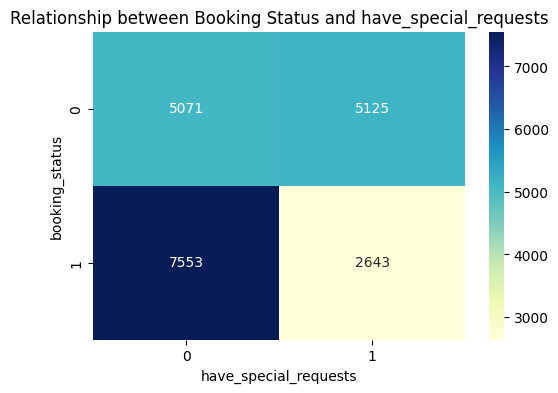

In [107]:
custom_heatmap(requests_col[0])

It is clear that customers with special requests are less likely to cancel their bookings, probably because they put in more effort to plan their trip.

## Feature Engineering on Price

These features may be related to avg_price_per_room: avg_price_per_room, type_of_meal_plan, room_type_reserved, market_segment_type, and their relationships are visualized below.

In [91]:
X_train[X_train['avg_price_per_room']==0]

,type_of_meal_plan_meal plan 1,type_of_meal_plan_meal plan 2,type_of_meal_plan_meal plan 3,type_of_meal_plan_not selected,room_type_reserved_room_type 1,room_type_reserved_room_type 2,room_type_reserved_room_type 3,room_type_reserved_room_type 4,room_type_reserved_room_type 5,room_type_reserved_room_type 6,...,perc_adults,no_of_nights,perc_weekday_nights,stay_type,diff_nights,no_of_previous_bookings,cancellation_type,previous_cancellation_rate,lead_time_cat,avg_price_per_room_cat
78,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1,0.00,weekday_only,1.0,4,all_successful,0.0,0 to 50,0 to 50
93,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2,0.00,weekday_only,1.0,0,no_booking,0.0,0 to 50,0 to 50
131,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2,0.00,weekday_only,1.0,0,no_booking,0.0,50 to 100,0 to 50
198,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2,0.50,mixed,0.0,0,no_booking,0.0,0 to 50,0 to 50
213,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0,NaN,hour_room,NaN,0,no_booking,0.0,0 to 50,0 to 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14098,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2,0.00,weekday_only,1.0,0,no_booking,0.0,greater than 300,0 to 50
14218,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0,NaN,hour_room,NaN,0,no_booking,0.0,200 to 300,0 to 50
15148,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4,0.25,mixed,0.5,0,no_booking,0.0,200 to 300,0 to 50
16395,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0,NaN,hour_room,NaN,0,no_booking,0.0,200 to 300,0 to 50


Bookings with avg_price_per_room=0 could be because the customers received some special promotion.

As including observations with avg_price_per_room=0 will greatly impact the average room price of different groups, we will exclude these observations from the following visualization.

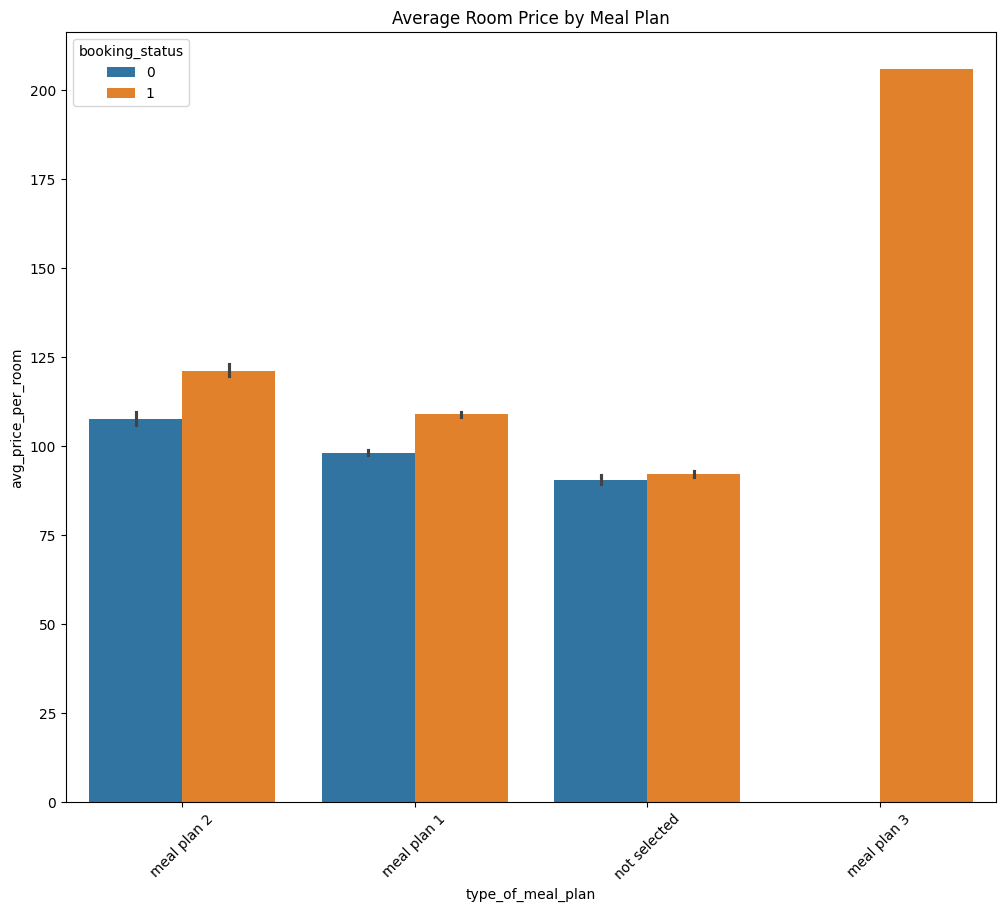

In [93]:
plt.figure(figsize=(12,10))
sns.barplot(x='type_of_meal_plan', y='avg_price_per_room', hue='booking_status', data=pd.concat([X_train, y_train], axis=1)[pd.concat([X_train, y_train], axis=1)['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Meal Plan')
plt.xticks(rotation=45)
plt.show()

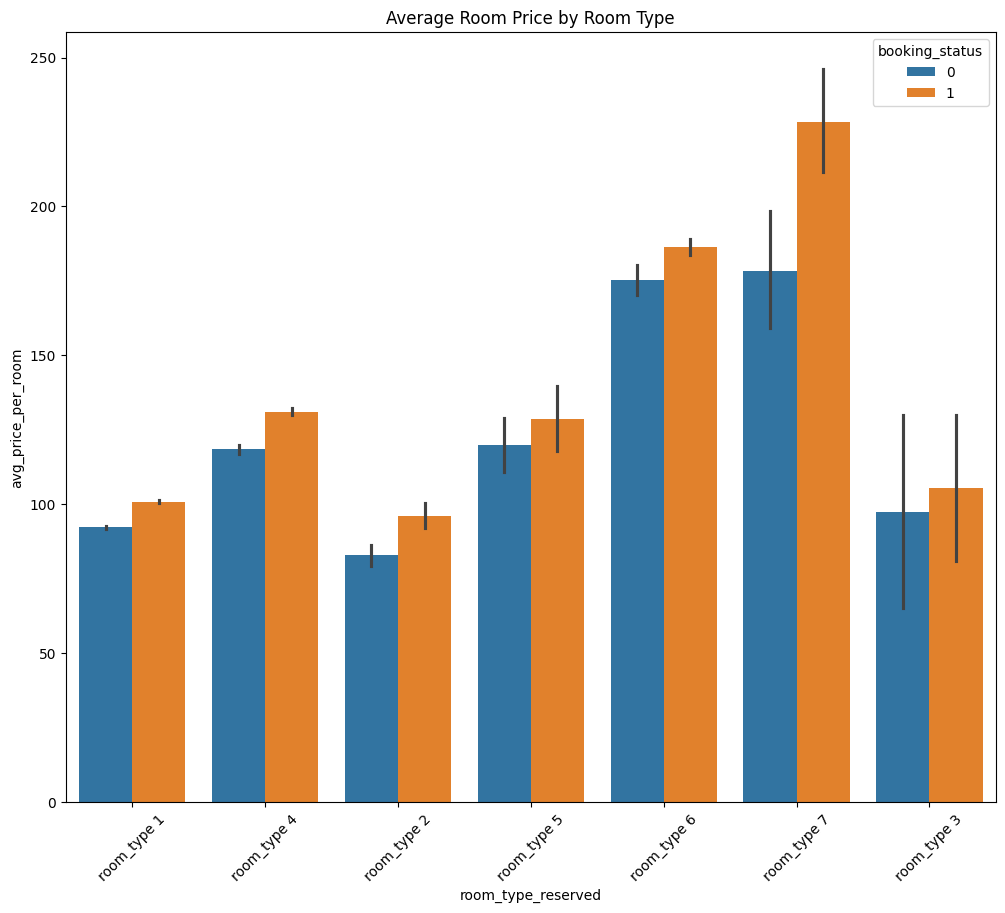

In [94]:
plt.figure(figsize=(12,10))
sns.barplot(x='room_type_reserved', y='avg_price_per_room', hue='booking_status', data=pd.concat([X_train, y_train], axis=1)[pd.concat([X_train, y_train], axis=1)['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Room Type')
plt.xticks(rotation=45)
plt.show()

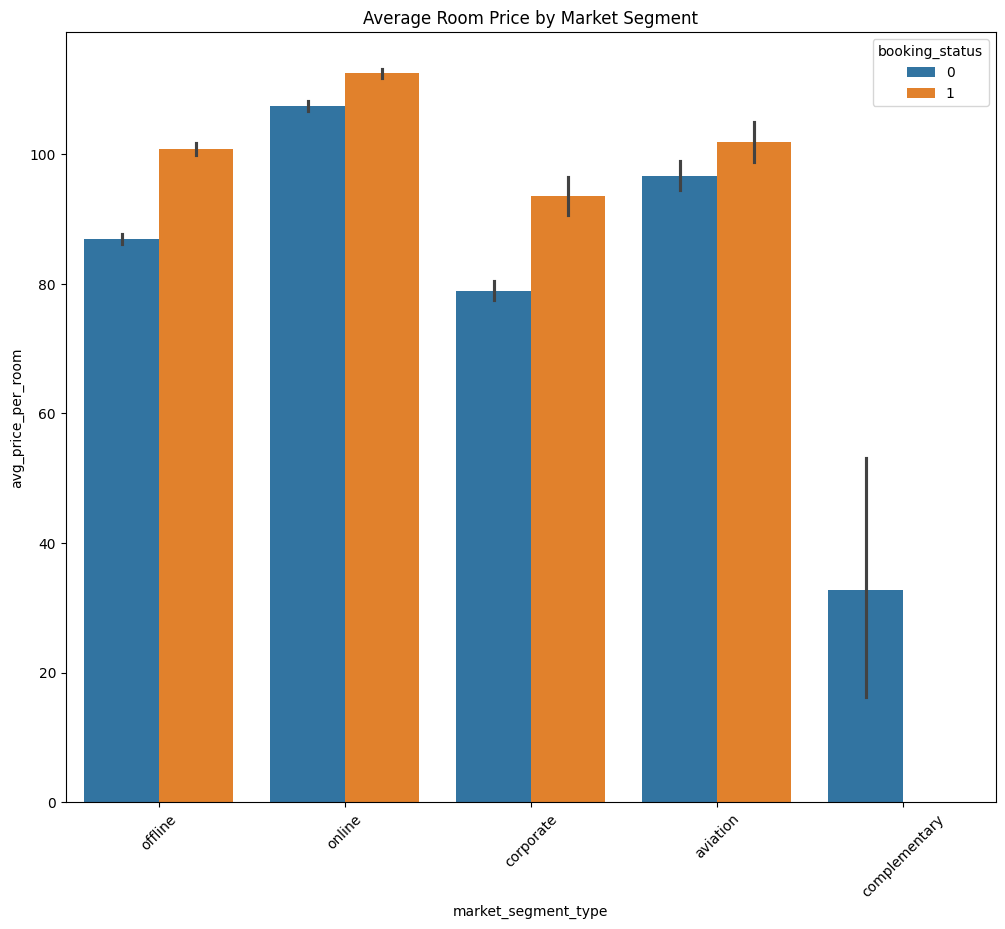

In [95]:
plt.figure(figsize=(12,10))
sns.barplot(x='market_segment_type', y='avg_price_per_room', hue='booking_status', data=pd.concat([X_train, y_train], axis=1)[pd.concat([X_train, y_train], axis=1)['avg_price_per_room']!=0])
plt.title(f'Average Room Price by Market Segment')
plt.xticks(rotation=45)
plt.show()

Despite that different categories in meal plan and room type have more similar price with intra-group observations compared with inter-group ones, no significant difference can be observed between cancelled and non-cancelled groups, which suggests that these features may not be useful for predicting cancellations.

## Feature Engineering on Dates

In [108]:
# this function will be used to create arrival date related features
def process_arrival_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['arrival_week'] = df['date'].dt.isocalendar().week.astype(float)
    df['arrival_dayofweek'] = df['date'].dt.dayofweek
    df['arrival_quarter'] = df['date'].dt.quarter
    df['arrival_dayofyear'] = df['date'].dt.dayofyear
    df['arrival_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)
    
    df.drop(columns='date', inplace=True)

In [109]:
# this function will be used to create booking date related features
def process_booking_date(df):
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    df['booking_year'] = df['booking_date'].dt.year
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    df['booking_quarter'] = df['booking_date'].dt.quarter
    df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    df['booking_date'] = df['booking_date'].dt.day
    df['booking_isweekend'] = df['arrival_dayofweek'].apply(lambda x:1 if x>=5 else 0)

In [110]:
# call the helper functions
process_arrival_date(X_train)
process_booking_date(X_train)

process_arrival_date(X_test)
process_booking_date(X_test)

In [111]:
# this function will be used to plot the number of cancelled bookings
def plot_dots_ordinal(feature, ax):
    dots = pd.concat([X_train, y_train], axis=1).groupby(feature)['booking_status'].sum().reset_index()
    dots.sort_values(feature, inplace=True)
    train_containers = ax.containers[0]
    
    containers = [train_containers]
    
    for container in containers:
        x_s = [bar.get_x() + bar.get_width()/2 for bar in container]
        y_s = dots.booking_status
        x_s = x_s[:y_s.shape[0]]
        ax.plot(x_s, y_s, marker='.', alpha=0.8, markersize=10)

Barplots are used to show the total number of booking, and lines show the number of canceled bookings.

In [112]:
arrival_columns = ['arrival_year', 'arrival_quarter', 'arrival_month', 'arrival_dayofweek', 
           'arrival_date', 'arrival_week', 'arrival_dayofyear', 'arrival_isweekend']
n_cols = 3
n_rows = math.ceil(len(arrival_columns)/n_cols)

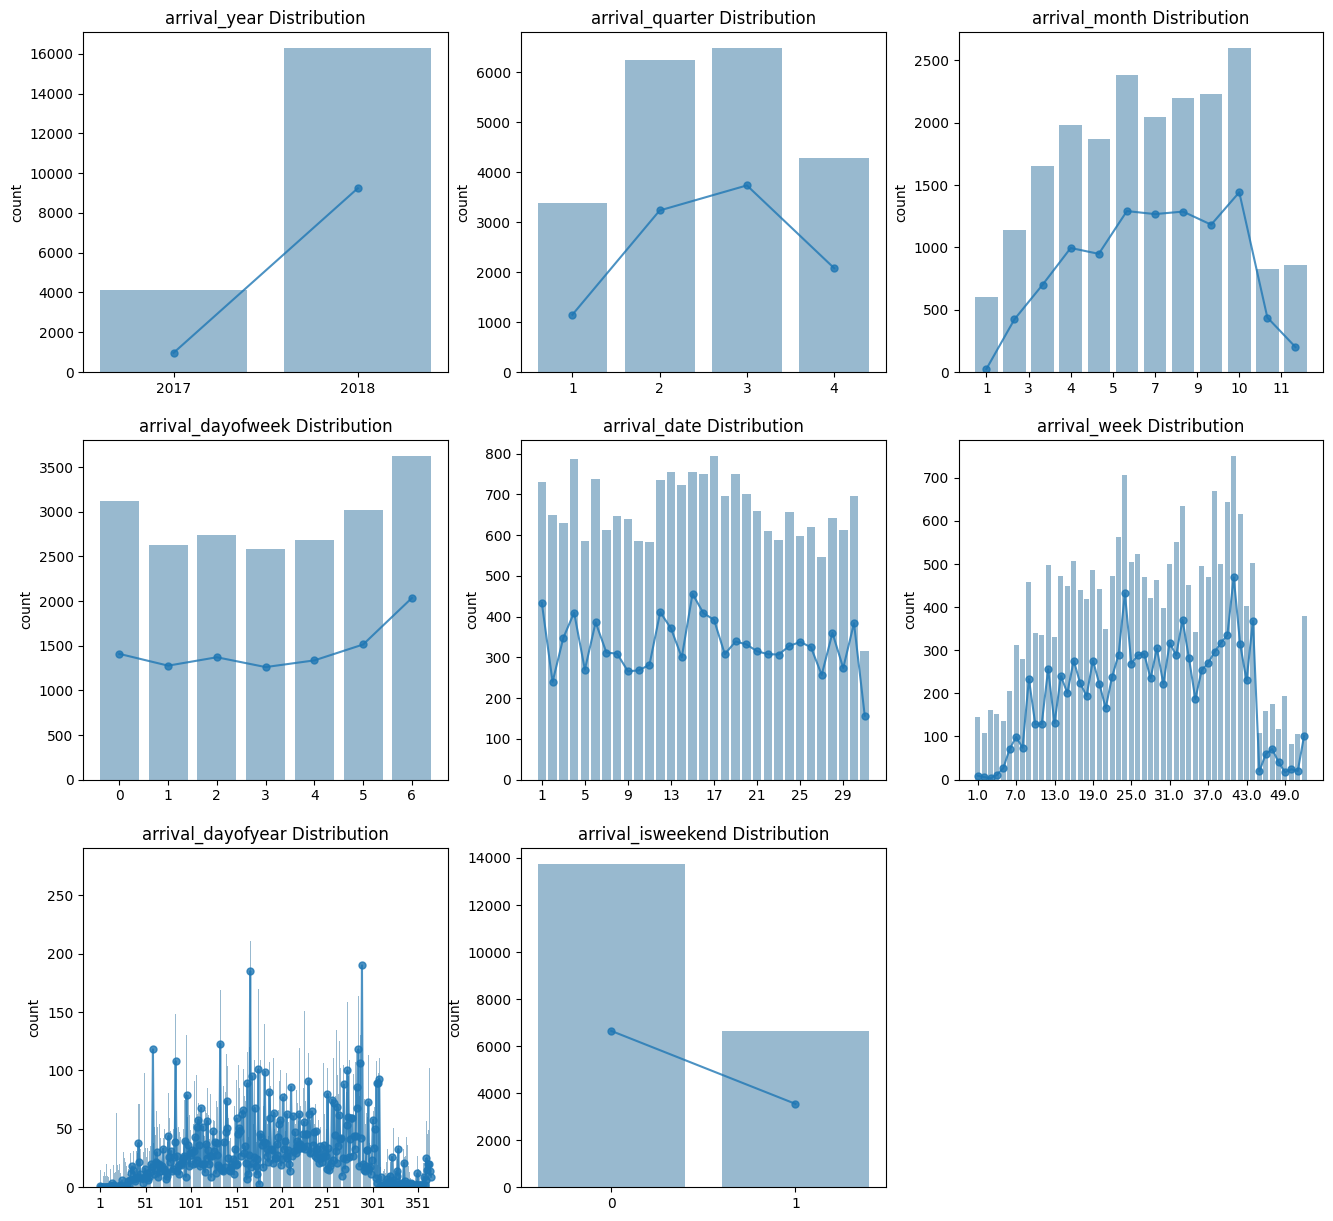

In [113]:
# visualize arrival date related features
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(arrival_columns):
    column = arrival_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=pd.concat([X_train, y_train], axis=1), x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    

In [115]:
booking_columns = ['booking_year', 'booking_quarter', 'booking_month', 'booking_dayofweek', 
           'booking_date', 'booking_week', 'booking_dayofyear', 'booking_isweekend']
n_cols = 3
n_rows = math.ceil(len(booking_columns)/n_cols)

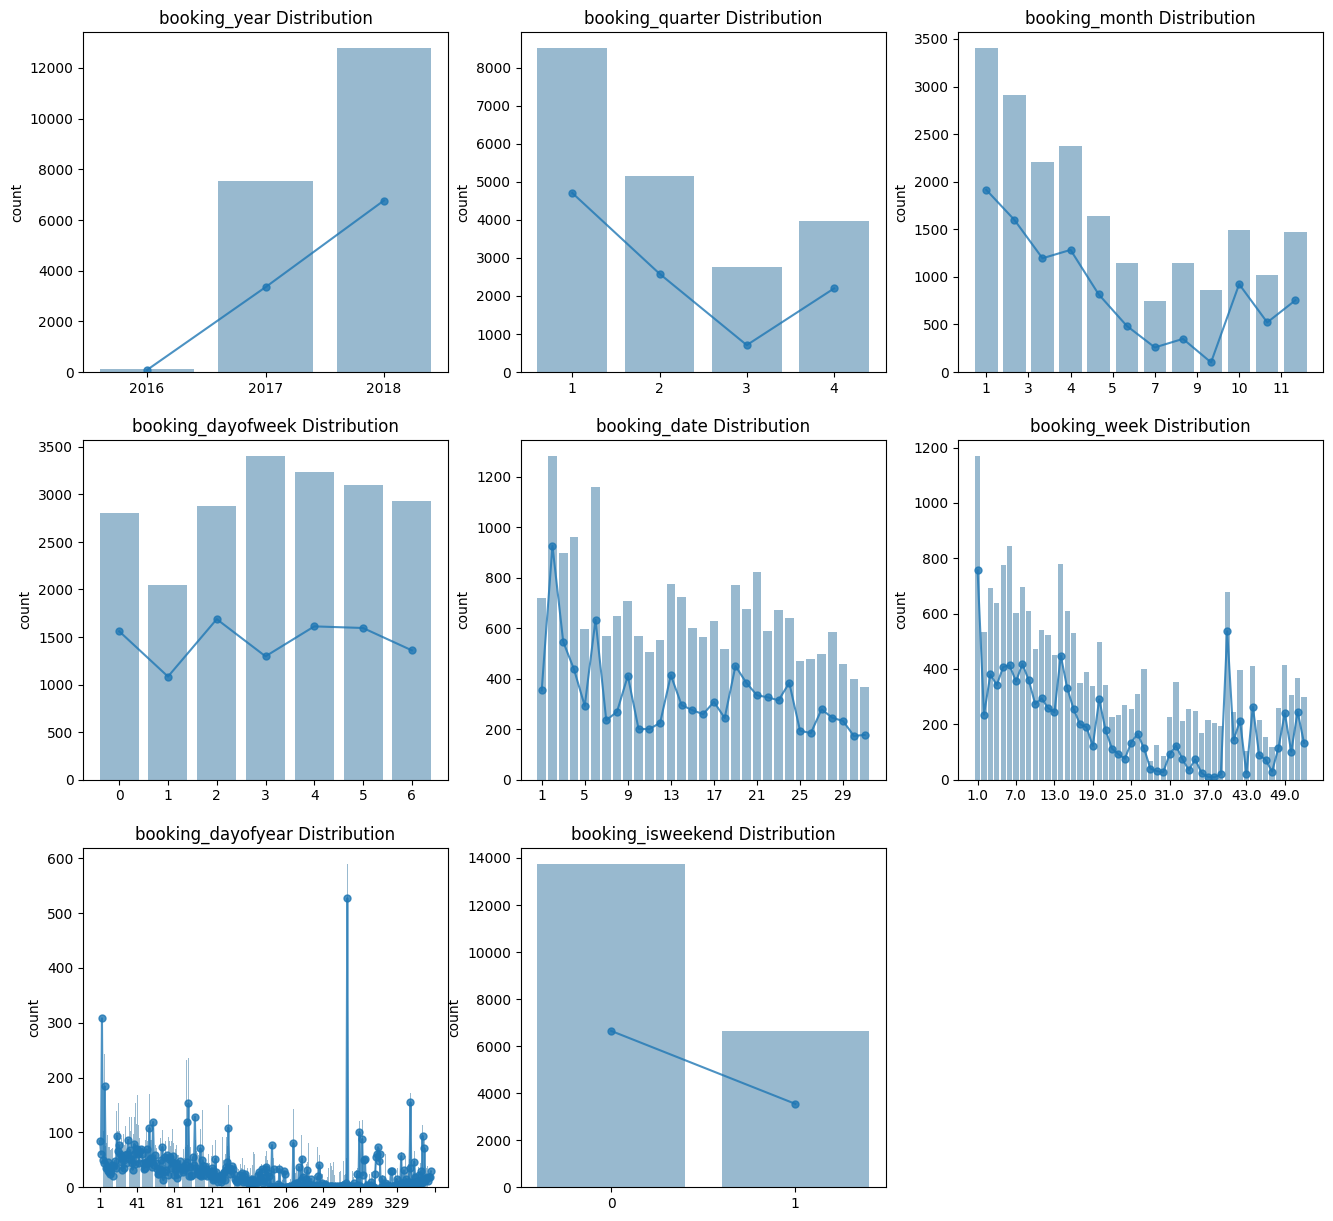

In [116]:
# visualize booking date related features
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(booking_columns):
    column = booking_columns[i]
    plot_axes = [ax[i]]
    sns.countplot(data=pd.concat([X_train, y_train], axis=1), x=column, ax=ax[i], alpha=0.5)
    plot_dots_ordinal(column, ax[i])
    
    # titles
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    
    # axis
    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

With the help of visualization, we can use the derived date columns in the following ways:
1. Arrival or booking year should not be used as features, because the newly injected data are likely to be in later years and we do not have long enough timeframe to capture the trend over years
2. Arrival or booking quarter/month could be useful features to keep, as they capture the seasonality within a year, as these 2 features are highly correlated, only one of them need to be kept, and encoded
3. Arrival or booking day of week can be encoded directly, or used to derive feature: whether arrival/booking on weekend
4. Arrival or booking date, week, and day of year may not be useful to keep, because of their high cardinality and insufficient number of observations under each category, which may lead to overfitting

## Process Newly Created Features

For these newly created features, we need to performance processing steps:
1. encode categorical variables with One-Hot Encoding
2. scale numerical variables with standardization

In [140]:
new_cat_cols = ['traveller_type', 'stay_type', 'cancellation_type', 
                'lead_time_cat', 'avg_price_per_room_cat', 
                'arrival_dayofweek', 'arrival_quarter', 'arrival_isweekend',
                'booking_month', 'booking_dayofweek', 'booking_quarter']
new_cat_cols_already_in_the_right_format = ['solo_traveller', 'have_special_requests', 'booking_isweekend']

In [141]:
# fit on training data
enc = OneHotEncoder(handle_unknown='error')
enc.fit(X_train[new_cat_cols])
X_train[enc.get_feature_names_out()] = enc.transform(X_train[new_cat_cols]).toarray()

In [142]:
# transform test data
X_test[enc.get_feature_names_out()] = enc.transform(X_test[new_cat_cols]).toarray()

In [153]:
# store the categorical column names after encoding
encoded_new_cat_cols = list(enc.get_feature_names_out())+new_cat_cols_already_in_the_right_format
encoded_new_cat_cols

['traveller_type_adults_only',
 'traveller_type_children_only',
 'traveller_type_mixed',
 'stay_type_hour_room',
 'stay_type_mixed',
 'stay_type_weekday_only',
 'stay_type_weekend_only',
 'cancellation_type_all_cancelled',
 'cancellation_type_all_successful',
 'cancellation_type_mixed',
 'cancellation_type_no_booking',
 'lead_time_cat_0 to 50',
 'lead_time_cat_100 to 150',
 'lead_time_cat_150 to 200',
 'lead_time_cat_200 to 300',
 'lead_time_cat_50 to 100',
 'lead_time_cat_greater than 300',
 'avg_price_per_room_cat_0 to 50',
 'avg_price_per_room_cat_100 to 150',
 'avg_price_per_room_cat_150 to 200',
 'avg_price_per_room_cat_200 to 300',
 'avg_price_per_room_cat_50 to 100',
 'avg_price_per_room_cat_greater than 300',
 'arrival_dayofweek_0',
 'arrival_dayofweek_1',
 'arrival_dayofweek_2',
 'arrival_dayofweek_3',
 'arrival_dayofweek_4',
 'arrival_dayofweek_5',
 'arrival_dayofweek_6',
 'arrival_quarter_1',
 'arrival_quarter_2',
 'arrival_quarter_3',
 'arrival_quarter_4',
 'arrival_isweeke

In [144]:
new_num_cols = ['no_of_customers', 'perc_adults', 'no_of_nights','perc_weekday_nights', 
                'diff_nights', 'no_of_previous_bookings', 'previous_cancellation_rate']

In [176]:
# fit on training data
scaler = StandardScaler()
scaler.fit(X_train[new_num_cols])
X_train[[x+'_scaled' for x in new_num_cols]] = scaler.transform(X_train[new_num_cols])

In [177]:
# transform test data
X_test[[x+'_scaled' for x in new_num_cols]] = scaler.transform(X_test[new_num_cols])

In [152]:
# store the numerical column names after scaling
scaled_new_num_cols = [x+'_scaled' for x in new_num_cols]
scaled_new_num_cols

['no_of_customers_scaled',
 'perc_adults_scaled',
 'no_of_nights_scaled',
 'perc_weekday_nights_scaled',
 'diff_nights_scaled',
 'no_of_previous_bookings_scaled',
 'previous_cancellation_rate_scaled']

## Columns Dependency Examination

In [154]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()
scaled_num_cols = [x for x in columns if 'scaled' in x]
encoded_cat_cols = [x for x in columns if 'scaled' not in x]

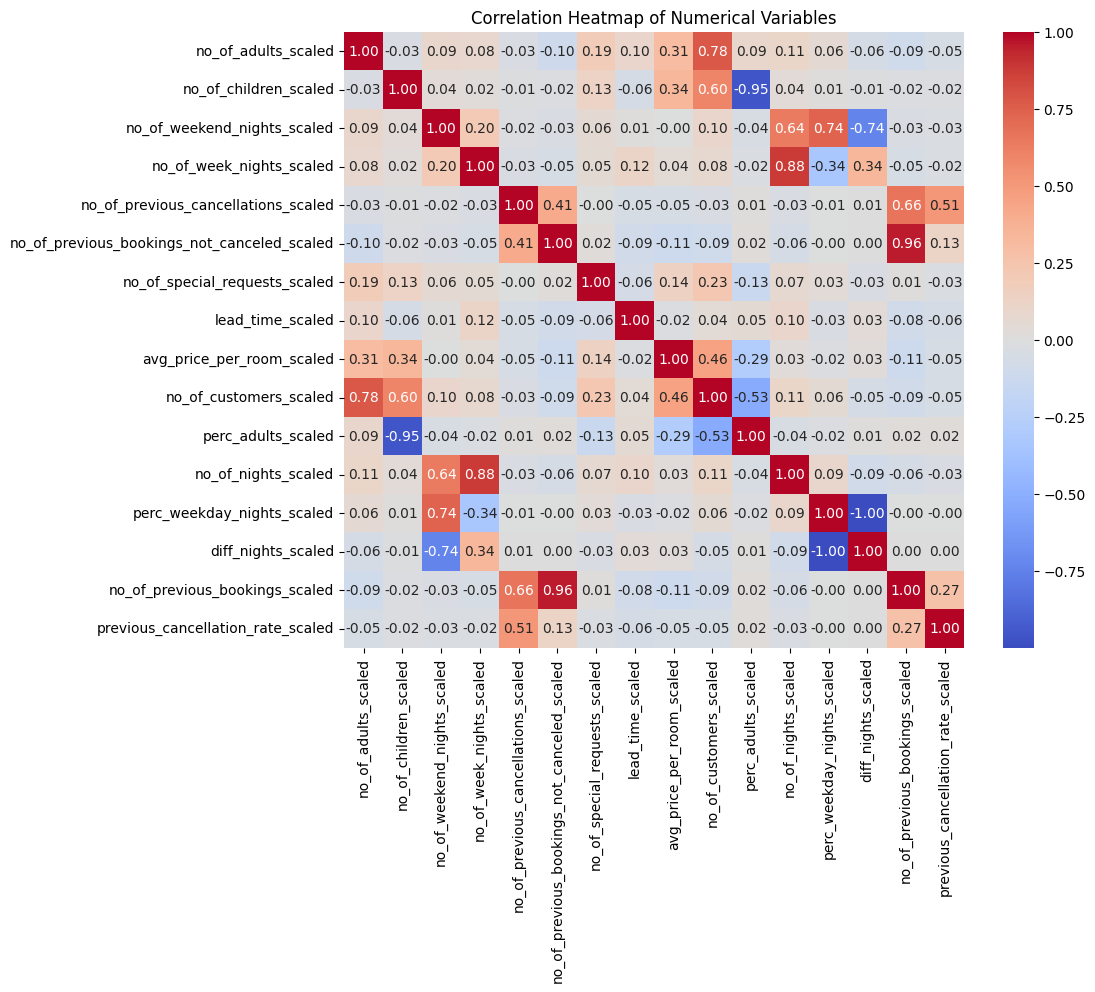

In [178]:
# test on numerical variables
corr = X_train[scaled_num_cols+scaled_new_num_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

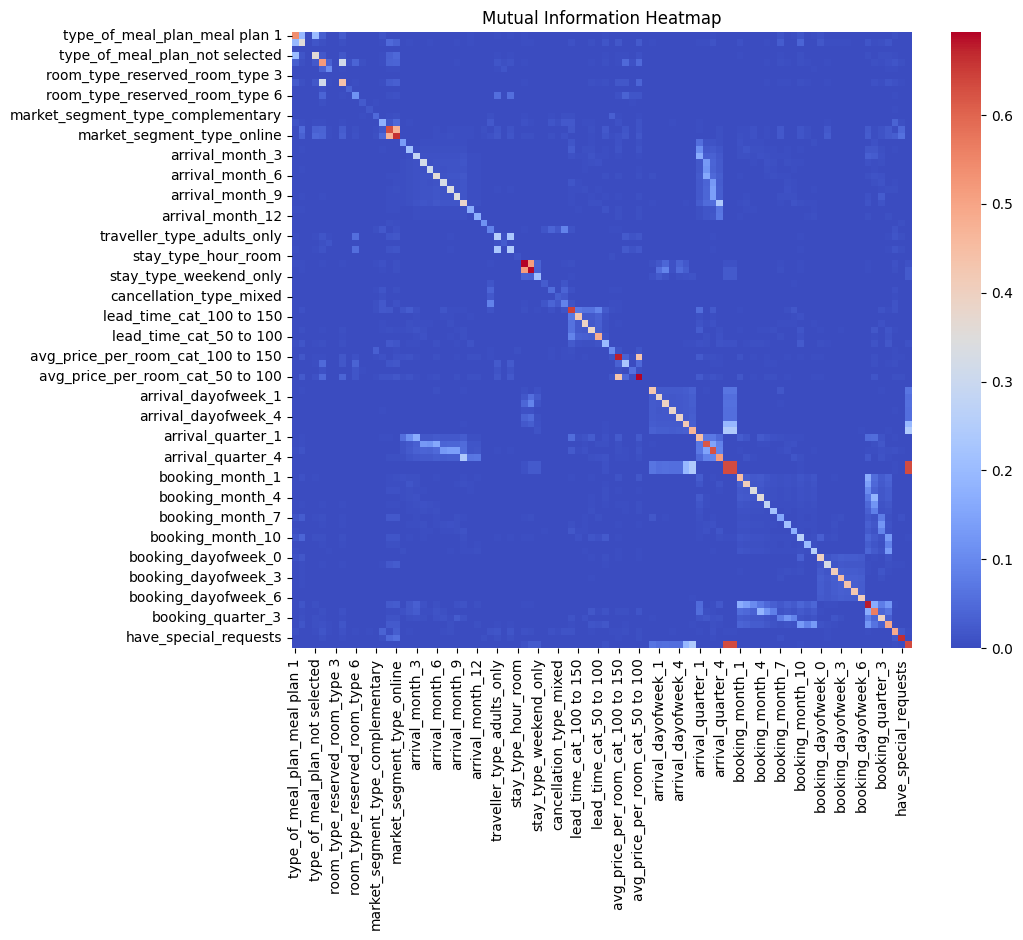

In [159]:
# calculate mutual information
def calculate_mutual_info(df, col1, col2):
    return mutual_info_score(df[col1], df[col2])


# plot heatmap
mi_matrix = pd.DataFrame(index=encoded_cat_cols+encoded_new_cat_cols, columns=encoded_cat_cols+encoded_new_cat_cols)
for i in encoded_cat_cols+encoded_new_cat_cols:
    for j in encoded_cat_cols+encoded_new_cat_cols:
        mi_matrix.loc[i, j] = calculate_mutual_info(X_train, i, j)

plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(mi_matrix.astype(float), cmap='coolwarm', fmt='.2f')
plt.title('Mutual Information Heatmap')
plt.show()

While some columns are dependent on each other, which one of them to exclude still depend on how much information each variable can bring to the model. Thus a more comprehensive feature selection will be done together with the models.

## Store the Engineered Datasets

In [207]:
X_train[encoded_new_cat_cols+scaled_new_num_cols+columns].to_csv('Data/X_train_engineered.csv', index = False)
X_test[encoded_new_cat_cols+scaled_new_num_cols+columns].to_csv('Data/X_test_engineered.csv', index = False)